# Seoul Bike Trip Duration Prediction

<img src="Features_Description.png" style="float:right;" width="500"/>

### Context
- Trip duration is the most fundamental measure in all modes of transportation. 
- Hence, it is crucial to predict the trip-time precisely for the advancement of Intelligent Transport Systems (ITS) and traveller information systems. 
- In order to predict the trip duration, data mining techniques are employed in this paper to predict the trip duration of rental bikes in Seoul Bike sharing system. 
- The prediction is carried out with the combination of Seoul Bike data and weather data.

### Content
- The Data used include trip duration, trip distance, pickup-dropoff latitude and longitude, 
temperature, precipitation, wind speed, humidity, solar radiation, snowfall, ground temperature and 1-hour average dust concentration.

### Acknowledgements
- V E, Sathishkumar (2020), "Seoul Bike Trip duration prediction", Mendeley Data, V1, doi: 10.17632/gtfh9z865f.1
- Sathishkumar V E, Jangwoo Park, Yongyun Cho, (2019), Seoul bike trip duration prediction using data mining techniques, IET Intelligent Transport Systems, doi: 10.1049/iet-its.2019.0796

### Goal
- Predict the trip duration

### Steps
- Exploratory Data Analysis (EDA)
- Data Preprocessing
- Feature Selection / Transformation
- **Mahcine Learning Algorithm**
- Feature Importance / Engineering
- Hyperparameter Tuning
- Model Deployment

## Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from helper_functions import *

from timeit import default_timer as timer

In [2]:
# import sklearn
# sklearn.__version__ #'0.22.1'

## Data

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, X_test, y_train, y_val, y_test = \
joblib.load('data/X_train.pkl'),\
joblib.load('data/X_val.pkl'),\
joblib.load('data/X_test.pkl'),\
joblib.load('data/y_train.pkl'),\
joblib.load('data/y_val.pkl'),\
joblib.load('data/y_test.pkl')

rfe_features = X_train.columns

train_dataset = X_train.copy()
train_dataset['Duration'] = y_train

In [4]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((7015172, 10), (876896, 10), (876897, 10), (7015172,), (876896,), (876897,))

### Feature scaling

In [5]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_val = scalar.transform(X_val)
X_test = scalar.transform(X_test)

## Machine Learning Algorithms

In [6]:
def fit_ML_model(modelName, model, error=pd.DataFrame(
    [], index=['Train Loss','Val Loss', 'Test Loss', 'y_mean','Time (s)'])):

    from sklearn.metrics import mean_squared_error
    
    start = timer()
    
    model.fit(X_train, y_train)
    rmse_train = mean_squared_error(y_train, model.predict(X_train))**0.5
    rmse_val = mean_squared_error(y_val, model.predict(X_val))**0.5
    rmse_test = mean_squared_error(y_test, model.predict(X_test))**0.5

    end = timer()

    error[modelName] = [rmse_train, rmse_val, rmse_test, y_train.mean(), end-start]

    return model, error

###  Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression

modelName = 'LinReg'
lr, error = fit_ML_model(modelName, LinearRegression())

feature_importances = pd.DataFrame(abs(lr.coef_), index=rfe_features, columns=[modelName])
feature_importances[modelName] /= feature_importances[modelName].max()

error

,LinReg
Train Loss,12.671839
Val Loss,12.671243
Test Loss,12.625706
y_mean,22.555679
Time (s),3.353774


### Random Forest

In [8]:
from sklearn.ensemble import RandomForestRegressor

modelName = 'RandForest'
rf = RandomForestRegressor(n_estimators=100, min_samples_split=10, n_jobs=-1)
rf, error = fit_ML_model(modelName, rf)

feature_importances[modelName] = rf.feature_importances_
feature_importances[modelName] /= feature_importances[modelName].max()

error

,LinReg,RandForest
Train Loss,12.671839,2.772410
Val Loss,12.671243,4.706530
Test Loss,12.625706,4.704562
y_mean,22.555679,22.555679
Time (s),3.353774,1107.632395


### XGBoost

In [10]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

modelName = 'XGBoost'
xgb = XGBRegressor(learning_rate=0.9, n_estimators=100, n_jobs=16,
                   tree_method='exact', eval_set=[(X_val, y_val)], 
                   early_stopping_rounds=10, verbose=1)
xgb, error = fit_ML_model(modelName, xgb)

feature_importances[modelName] = xgb.feature_importances_
feature_importances[modelName] /= feature_importances[modelName].max()

error

[17:54:21] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds", "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,LinReg,RandForest,XGBoost
Train Loss,12.671839,2.772410,3.644628
Val Loss,12.671243,4.706530,3.720178
Test Loss,12.625706,4.704562,3.722469
y_mean,22.555679,22.555679,22.555679
Time (s),3.353774,1107.632395,283.478313


### Neural Network

In [12]:
import tensorflow as tf
from tensorflow import keras

nodes = 64
n_hidden = 2
activation = 'relu'

ann = tf.keras.Sequential(keras.layers.Dense(nodes, activation=activation, input_shape=X_train.shape[1:]))

for _ in range(n_hidden-1):  
    ann.add(keras.layers.Dense(nodes, activation=activation))

ann.add(keras.layers.Dense(1))

ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


In [13]:
epochs = 500
batch_size = 10000

lr =1e-3 

optimizer = tf.keras.optimizers.Adam(learning_rate=lr) 
ann.compile(loss='mean_squared_error', optimizer=optimizer)

start = timer()
history = ann.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    epochs=epochs, batch_size=batch_size, validation_batch_size=batch_size)
end = timer()

Epoch 1/500
702/702 [==============================] - 6s 7ms/step - loss: 383.8932 - val_loss: 101.9502
Epoch 2/500
702/702 [==============================] - 4s 5ms/step - loss: 81.3530 - val_loss: 25.2560
Epoch 3/500
702/702 [==============================] - 4s 5ms/step - loss: 17.7649 - val_loss: 9.7545
Epoch 4/500
702/702 [==============================] - 4s 5ms/step - loss: 9.1930 - val_loss: 7.6144
Epoch 5/500
702/702 [==============================] - 4s 5ms/step - loss: 7.3679 - val_loss: 6.1390
Epoch 6/500
702/702 [==============================] - 4s 5ms/step - loss: 5.9150 - val_loss: 5.0516
Epoch 7/500
702/702 [==============================] - 3s 5ms/step - loss: 5.0192 - val_loss: 4.3683
Epoch 8/500
702/702 [==============================] - 3s 5ms/step - loss: 4.3084 - val_loss: 3.9940
Epoch 9/500
702/702 [==============================] - 4s 5ms/step - loss: 4.1394 - val_loss: 3.8436
Epoch 10/500
702/702 [==============================] - 4s 5ms/step - loss: 4.0246 -

702/702 [==============================] - 4s 5ms/step - loss: 1.8621 - val_loss: 1.8606
Epoch 82/500
702/702 [==============================] - 4s 5ms/step - loss: 1.8389 - val_loss: 1.8544
Epoch 83/500
702/702 [==============================] - 4s 5ms/step - loss: 1.8814 - val_loss: 1.8666
Epoch 84/500
702/702 [==============================] - 4s 5ms/step - loss: 1.8679 - val_loss: 1.8893
Epoch 85/500
702/702 [==============================] - 4s 5ms/step - loss: 1.8643 - val_loss: 1.8592
Epoch 86/500
702/702 [==============================] - 4s 5ms/step - loss: 1.8723 - val_loss: 1.8483
Epoch 87/500
702/702 [==============================] - 4s 5ms/step - loss: 1.8798 - val_loss: 1.8660
Epoch 88/500
702/702 [==============================] - 4s 5ms/step - loss: 1.8464 - val_loss: 1.8455
Epoch 89/500
702/702 [==============================] - 4s 5ms/step - loss: 1.9047 - val_loss: 1.8623
Epoch 90/500
702/702 [==============================] - 4s 5ms/step - loss: 1.8427 - val_loss: 

Epoch 161/500
702/702 [==============================] - 4s 5ms/step - loss: 1.7787 - val_loss: 1.7973
Epoch 162/500
702/702 [==============================] - 3s 5ms/step - loss: 1.7951 - val_loss: 1.7755
Epoch 163/500
702/702 [==============================] - 4s 5ms/step - loss: 1.8190 - val_loss: 1.8062
Epoch 164/500
702/702 [==============================] - 4s 5ms/step - loss: 1.7967 - val_loss: 1.7917
Epoch 165/500
702/702 [==============================] - 3s 5ms/step - loss: 1.7732 - val_loss: 1.8312
Epoch 166/500
702/702 [==============================] - 4s 5ms/step - loss: 1.8117 - val_loss: 1.7804
Epoch 167/500
702/702 [==============================] - 3s 5ms/step - loss: 1.7747 - val_loss: 1.7810
Epoch 168/500
702/702 [==============================] - 3s 5ms/step - loss: 1.7741 - val_loss: 1.7770
Epoch 169/500
702/702 [==============================] - 3s 5ms/step - loss: 1.7515 - val_loss: 1.7834
Epoch 170/500
702/702 [==============================] - 3s 5ms/step - lo

702/702 [==============================] - 3s 5ms/step - loss: 1.7752 - val_loss: 1.7653
Epoch 241/500
702/702 [==============================] - 4s 5ms/step - loss: 1.7716 - val_loss: 1.7977
Epoch 242/500
702/702 [==============================] - 4s 5ms/step - loss: 1.7670 - val_loss: 1.7639
Epoch 243/500
702/702 [==============================] - 4s 5ms/step - loss: 1.7724 - val_loss: 1.7517
Epoch 244/500
702/702 [==============================] - 3s 5ms/step - loss: 1.7481 - val_loss: 1.7601
Epoch 245/500
702/702 [==============================] - 4s 5ms/step - loss: 1.7425 - val_loss: 1.7603
Epoch 246/500
702/702 [==============================] - 4s 5ms/step - loss: 1.7851 - val_loss: 1.7889
Epoch 247/500
702/702 [==============================] - 3s 5ms/step - loss: 1.7642 - val_loss: 1.7828
Epoch 248/500
702/702 [==============================] - 3s 5ms/step - loss: 1.7638 - val_loss: 1.7455
Epoch 249/500
702/702 [==============================] - 4s 5ms/step - loss: 1.7748 - v

702/702 [==============================] - 4s 5ms/step - loss: 1.7530 - val_loss: 1.7339
Epoch 320/500
702/702 [==============================] - 4s 5ms/step - loss: 1.7479 - val_loss: 1.7424
Epoch 321/500
702/702 [==============================] - 4s 5ms/step - loss: 1.7419 - val_loss: 1.7414
Epoch 322/500
702/702 [==============================] - 3s 5ms/step - loss: 1.7303 - val_loss: 1.7408
Epoch 323/500
702/702 [==============================] - 4s 5ms/step - loss: 1.7664 - val_loss: 1.7352
Epoch 324/500
702/702 [==============================] - 3s 5ms/step - loss: 1.7540 - val_loss: 1.7390
Epoch 325/500
702/702 [==============================] - 4s 5ms/step - loss: 1.7074 - val_loss: 1.7552
Epoch 326/500
702/702 [==============================] - 4s 5ms/step - loss: 1.7398 - val_loss: 1.7426
Epoch 327/500
702/702 [==============================] - 3s 5ms/step - loss: 1.7583 - val_loss: 1.7482
Epoch 328/500
702/702 [==============================] - 3s 5ms/step - loss: 1.7654 - v

702/702 [==============================] - 4s 5ms/step - loss: 1.7161 - val_loss: 1.7403
Epoch 399/500
702/702 [==============================] - 4s 5ms/step - loss: 1.7156 - val_loss: 1.7109
Epoch 400/500
702/702 [==============================] - 3s 5ms/step - loss: 1.7673 - val_loss: 1.7340
Epoch 401/500
702/702 [==============================] - 4s 5ms/step - loss: 1.6893 - val_loss: 1.6962
Epoch 402/500
702/702 [==============================] - 3s 5ms/step - loss: 1.7166 - val_loss: 1.7121
Epoch 403/500
702/702 [==============================] - 4s 5ms/step - loss: 1.7206 - val_loss: 1.7017
Epoch 404/500
702/702 [==============================] - 4s 5ms/step - loss: 1.7119 - val_loss: 1.7058
Epoch 405/500
702/702 [==============================] - 3s 5ms/step - loss: 1.7201 - val_loss: 1.7106
Epoch 406/500
702/702 [==============================] - 4s 5ms/step - loss: 1.6786 - val_loss: 1.7053
Epoch 407/500
702/702 [==============================] - 3s 5ms/step - loss: 1.7038 - v

702/702 [==============================] - 3s 5ms/step - loss: 1.7099 - val_loss: 1.6741
Epoch 478/500
702/702 [==============================] - 4s 5ms/step - loss: 1.6828 - val_loss: 1.6979
Epoch 479/500
702/702 [==============================] - 4s 5ms/step - loss: 1.6795 - val_loss: 1.6741
Epoch 480/500
702/702 [==============================] - 4s 5ms/step - loss: 1.6750 - val_loss: 1.6953
Epoch 481/500
702/702 [==============================] - 3s 5ms/step - loss: 1.7037 - val_loss: 1.6856
Epoch 482/500
702/702 [==============================] - 4s 5ms/step - loss: 1.7117 - val_loss: 1.6667
Epoch 483/500
702/702 [==============================] - 4s 5ms/step - loss: 1.6904 - val_loss: 1.6979
Epoch 484/500
702/702 [==============================] - 4s 5ms/step - loss: 1.7027 - val_loss: 1.6934
Epoch 485/500
702/702 [==============================] - 4s 5ms/step - loss: 1.6872 - val_loss: 1.6756
Epoch 486/500
702/702 [==============================] - 4s 5ms/step - loss: 1.6906 - v

In [19]:
# still need to find a good way to determine feature importance using NN
# feature_importances['NN_CPU'] =np.mean(abs(ann.weights[0]), axis=1)

In [15]:
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(y_train, ann.predict(X_train, batch_size=batch_size))**0.5
rmse_val = mean_squared_error(y_val, ann.predict(X_val, batch_size=batch_size))**0.5
rmse_test = mean_squared_error(y_test, ann.predict(X_test, batch_size=batch_size))**0.5
error['NN_CPU'] = [rmse_train, rmse_val, rmse_test, y_train.mean(), end-start]
error

,LinReg,RandForest,XGBoost,NN_CPU
Train Loss,12.671839,2.772410,3.644628,1.294142
Val Loss,12.671243,4.706530,3.720178,1.294802
Test Loss,12.625706,4.704562,3.722469,1.295741
y_mean,22.555679,22.555679,22.555679,22.555679
Time (s),3.353774,1107.632395,283.478313,1780.397644


### Plotting best results (NN)

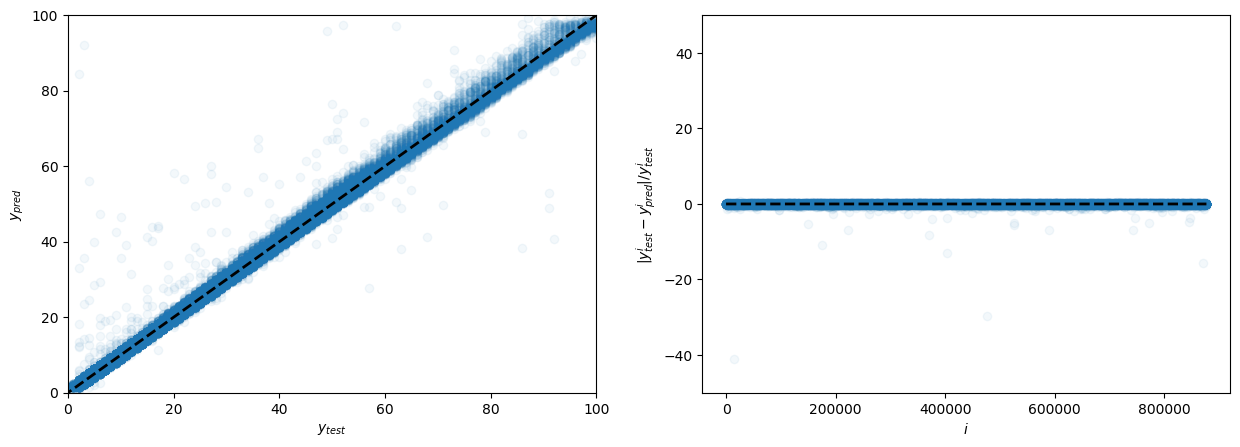

In [16]:
y_pred = ann.predict(X_test, batch_size=batch_size)
rel_res = (y_test.values-y_pred[:,0])/y_test.values

plot_idx = np.random.choice(range(len(y_test)), size=len(y_test)//10, replace=False)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5), dpi=100)

ax[0].scatter(y_test.values[plot_idx], y_pred[:,0][plot_idx], alpha=0.05);
ax[0].set_xlabel('$y_{test}$')
ax[0].set_ylabel('$y_{pred}$')
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,100)
ax[0].plot(range(-10,130), range(-10,130), '--k', lw=2);

ax[1].scatter(np.arange(len(rel_res))[plot_idx], rel_res[plot_idx], alpha=0.05);
ax[1].set_xlabel('$i$')
ax[1].set_ylabel('$|y_{test}^i-y_{pred}^i|/y_{test}^i$');
ax[1].plot(range(len(rel_res)), 0*np.arange(len(rel_res)), '--k', lw=2);
ax[1].set_ylim(-50,50);

# sns.kdeplot(y_test.values-y_pred[:,0], ax=ax[1], shade=True)
# ax[1].set_xlim(-50,50);

## Feature Importance

In [17]:
df_corr = train_dataset.corr()
feature_importances['Duration_Corr'] = df_corr['Duration'].abs().sort_values()[:-1]

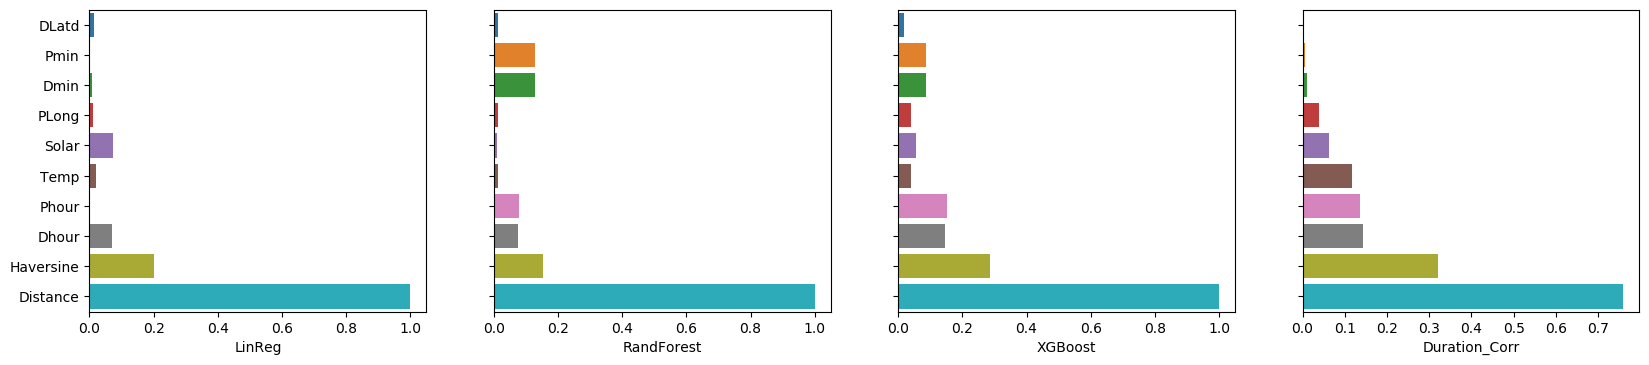

In [22]:
feature_importances = feature_importances.sort_values('Duration_Corr')

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20,4), dpi=100, sharey=True)

sns.barplot(y=feature_importances.index, x= feature_importances.LinReg, ax=ax[0])
sns.barplot(y=feature_importances.index, x= feature_importances.RandForest, ax=ax[1])
sns.barplot(y=feature_importances.index, x= feature_importances.XGBoost, ax=ax[2])
sns.barplot(y=feature_importances.index, x= feature_importances.Duration_Corr, ax=ax[3]);

### Hyperparameters Tuning